# Orthogroup analysis of matrisoms
This pipeline takes multiple collections of proteins from different species and performs an orthogroup analysis with the goal of grouping orthologues together.
It expects a folder with fasta files named in this pattern "Taxonomic_group_Genus_species.fasta"

CITATION:

 When publishing work that uses OrthoFinder please cite:
 > Emms D.M. & Kelly S. (2019), Genome Biology 20:238

 If you use the species tree in your work then please also cite:
 >Emms D.M. & Kelly S. (2017), MBE 34(12): 3267-3278
 >
 >Emms D.M. & Kelly S. (2018), bioRxiv https://doi.org/10.1101/267914

## Install orthofinder


We need to import a number of packages

In [3]:
# pip install pandas seaborn matplotlib biopython matplotlib-venn tqdm holoviews bokeh adjustText venn ipykerne openpyxl
from pathlib import Path
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from Bio import Phylo,SeqIO
from matplotlib_venn import venn2,venn3 # A library for creating venn diagrams
from tqdm import tqdm # A library for creating progress bars
import holoviews as hv # A library for creating interactive visualizations
from bokeh.io import export_svgs
from venn import venn
from adjustText import adjust_text
import numpy as np
import warnings
from Bio import BiopythonParserWarning

AttributeError: module 'numpy' has no attribute 'ndarray'

In [ ]:
#define where the input files are
input_folder = Path(r"./output/orthofinder_input/core")

#where did you install orthofinder?
orthofinder_directory = Path(r"./orthofinder/OrthoFinder/orthofinder")

#where do you want to save the resulting statistics, graphs and images
output_path = input_folder / "Orthogroup_analysis"
graph_path = output_path / "graphs"
graph_path.mkdir(parents = True, exist_ok = True)
image_path = output_path / "image"
image_path.mkdir(parents = True, exist_ok = True)

color_map = ["#AFDB00","#72BCE4","#FF00FF","#FF7F0E"]
colors = {  'Choanozoa':"#ff2a7f",
            'Chordata':"#beaed4",
            'Anthozoa':"#ed7d31",
            'Cubozoa': "#bdd7ee",
            'Hydrozoa':"#00b0f0",
            'Scyphozoa':"#4472c4",
            'Staurozoa':"#1f4e79", 
            'Ctenophora':"#ffc000", 
            'Myxozoa':"#8faadc", 
            'Nematoda':"#ffff99",
            'Placozoa':"#666666", 
            'Porifera':"#800000", 
            'Platyhelminthes':"#FF7F0E",
            'Insecta':"#AFDB00"}

candidates = pd.read_excel("Candidate Liste.xlsx",index_col=0)


In [ ]:
# Functions
def replace_uppercase_with_lowercase(match):
    """
    Helper function to convert the first character of a matched pattern to lowercase.

    Parameters:
        match (re.Match): A regular expression match object.

    Returns:
        str: Modified string with first character in lowercase.
    """
    return match.group(0).lower()[0]

def assign_color(row,col_name):
    """
    Assign color category based on the 'Category' column values.

    Parameters:
        row (pd.Series): A row from the dataframe.

    Returns:
        str: Assigned color category.
    """
    if row[col_name][0] == 'Cnidaria':
        return row[col_name][1]
    return row[col_name][0]

def is_overlapping(x, y, text, existing_positions, threshold=10):
    """
    Check if a text label overlaps with existing positions.

    Parameters:
        x (float): x-coordinate of the text label.
        y (float): y-coordinate of the text label.
        text (str): Text label.
        existing_positions (list): List of existing positions.
        threshold (int, optional): Threshold for overlap detection. Default is 10.

    Returns:
        bool: True if there is overlap, False otherwise.
    """
    for pos in existing_positions:
        if abs(x - pos[0]) < threshold and abs(y - pos[1]) < threshold:
            return True
    return False

def scatter_plot_with_labels(dataframe,seq_row,OG_row, include_labels=None,):
    """
    Generate a scatter plot with optional labels for specific rows.

    Parameters:
        dataframe (pd.DataFrame): Input dataframe containing 'Matrisome size', '# Orthogroups', and 'Color Category' columns.
        include_labels (list, optional): List of labels to include. If None, all labels will be included. Default is None.

    Returns:
        None
    """
    cleaned_dataframe = dataframe.dropna()

    # Create the scatter plot
    plt.scatter(cleaned_dataframe[seq_row], cleaned_dataframe[OG_row], c=cleaned_dataframe['Color Category'].map(colors))
    plt.xlabel("Matrisome size")
    plt.ylabel("# Orthogroups")

    texts = []     
    for i, row in cleaned_dataframe.iterrows():
        # Check if label should be included
        if not include_labels or row['name'] in include_labels:
            texts.append(plt.text(row[seq_row] + 30, row[OG_row], row['name'], fontsize=6,color=colors.get(row['Color Category'],"black")))

    if len(texts) > 1:
        # Adjust text positions to avoid overlap
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))

OrthoFinder will be run manually because it takes a lot of time to finish and I want to ive the user the control over when it is being run. But I will build the command line arguments.

In [ ]:
#-f /mnt/d/Data/programs/mesoglea_protein_pipeline/output/orthofinder_input/matrisome -t 14 -a 14;
command = f'\u001b[33m{orthofinder_directory}\033[0m '
command += f'\033[1;32;1m-f\033[0m /mnt/{input_folder} '#input path (the /mnt/  allows me to access winsowds files from the WSL)
command += f'\033[1;32;1m-t\033[0m 14 ' #number of threads
command += f'\033[1;32;1m-a\033[0m 14 ' #number of threads for BLAST alignment
command = command.replace("\\","/")
command = re.sub(r"[A-Z]:",replace_uppercase_with_lowercase,command)
print("Run this command:")
print("ulimit -n 4000")
print(command)

Run this command:
ulimit -n 4000
orthofinder/OrthoFinder/orthofinder -f /mnt/output/orthofinder_input/core -t 14 -a 14 


This will create a new folder in the input directory which contains the Result files. each run creates a new subfolder so we need to select the latest run.

In [ ]:
# Get a list of all the directories in the OrthoFinder directory
orthofinder_dirs = [p for p in Path(f"{input_folder}/OrthoFinder").iterdir() if p.is_dir()]
#Sort the directories by name
orthofinder_dirs.sort()
# Find the most recent run by taking the last element in the sorted list
most_recent_run = orthofinder_dirs[-1]
# Use the most recent run to create the orthofinder_dir
orthofinder_dir = f"{most_recent_run}/"
OF_path = orthofinder_dir
print("Selected OrthoFinder Analysis:")
print(f'\033[1;32;1m{OF_path}\033[0m')

Selected OrthoFinder Analysis:
output\orthofinder_input\core\OrthoFinder\Results_Oct11_1/


The first qualti control check we want to do is to check the resulting species tree. Orthofinder creates a species Tree based on the defined orthogroups (you can also provide it with a tree as input to refine your analysis). This tree can give us some idea about large scale problems with our dataset. 

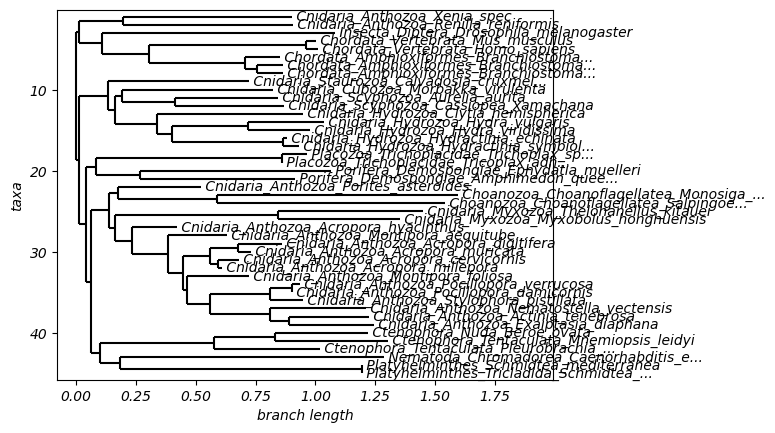

<Figure size 640x480 with 0 Axes>

In [ ]:
# Read the tree file
tree = Phylo.read(OF_path + "Species_Tree/SpeciesTree_rooted.txt", "newick")
# Draw the full matrisome tree
plt.title = "Species Tree"

Phylo.draw(tree)

plt.savefig(image_path / f"species_tree.svg")

How many orthogroups were found?

In [ ]:
OF_path

'output\\orthofinder_input\\core\\OrthoFinder\\Results_Oct11_1/'

In [ ]:
# count total orthogroups
OGs = pd.read_csv(
    OF_path + "Orthogroups/Orthogroups.tsv",
    sep="\t",
    index_col=0,
)
HOGs = pd.read_csv(
    OF_path + "/Phylogenetic_Hierarchical_Orthogroups/N0.tsv",
    sep="\t",
    index_col=0,
)
print(f"Identified {OGs.shape[0]} Orthogroups(OG).")
print(f"Identified {HOGs.shape[0]} Phylogenetically Hirarchical Orthogroups (HOGS).")

Identified 1891 Orthogroups(OG).
Identified 2928 Phylogenetically Hirarchical Orthogroups (HOGS).


In [ ]:
HOGs.columns[::-1]

Index(['Porifera_Demospongiae_Ephydatia_muelleri',
       'Porifera_Demospongiae_Amphimedon_queenslandica',
       'Platyhelminthes_Tricladida_Schmidtea_mediterranea',
       'Platyhelminthes_Schmidtea_mediterranea',
       'Placozoa_Trichoplacidae_Tricoplax_adhaerens',
       'Placozoa_Trichoplacidae_Trichoplax_specH2',
       'Nematoda_Chromadorea_Caenorhabditis_elegans',
       'Insecta_Diptera_Drosophila_melanogaster',
       'Ctenophora_Tentaculata_Pleurobrachia_bachei',
       'Ctenophora_Tentaculata_Mnemiopsis_leidyi',
       'Ctenophora_Nuda_Beroe_ovata',
       'Cnidaria_Staurozoa_Calvadosia_cruxmelitensis',
       'Cnidaria_Scyphozoa_Cassiopea_xamachana',
       'Cnidaria_Scyphozoa_Aurelia_aurita',
       'Cnidaria_Myxozoa_Thelohanellus_kitauei',
       'Cnidaria_Myxozoa_Myxobolus_honghuensis',
       'Cnidaria_Hydrozoa_Hydractinia_symbiolongicarpus',
       'Cnidaria_Hydrozoa_Hydractinia_echinata',
       'Cnidaria_Hydrozoa_Hydra_vulgaris',
       'Cnidaria_Hydrozoa_Hydra_vi

How many Orthogroups do the different species have?

In [ ]:
#a number of columns need to be dropped
exclude_list = ["OG","Gene Tree Parent Clade"]
HOG_count = HOGs.count().sort_index().drop(exclude_list)
HOG_count.to_csv(output_path  / "HOGs_per_species.csv")
HOG_count = HOG_count.drop(['Chordata_Amphioxiformes_Branchiostoma_lanceolatum',
       'Chordata_Amphioxiformes_Branchiostoma_floridae',
       'Chordata_Amphioxiformes_Branchiostoma_belcheri',])
custom_order = ["Choanozoa",
                "Porifera",
                "Ctenophora",
                "Placozoa",
                "Cnidaria",
                "Nematoda",
                "Insecta",
                "Platyhelminthes",
                "Chordata"]
HOG_count.index = pd.MultiIndex.from_tuples(HOG_count.index.str.split('_', expand=True),names = ["phylum","class","genus","species"])
HOG_count = pd.DataFrame(HOG_count, columns=["# Orthogroups"])
HOG_count

# Orthogroups
phylum          class             genus          species                         
Choanozoa       Choanoflagellatea Monosiga       brevicollis                   95
                                  Salpingoeca    rosetta                      142
Chordata        Vertebrata        Homo           sapiens                      180
                                  Mus            musculus                     179
Cnidaria        Anthozoa          Acropora       cervicornis                  554
                                                 digitifera                   509
                                                 hyacinthus                   293
                                                 millepora                    495
                                                 muricata                     220
                                  Actinia        tenebrosa                    577
                                  Exaiptasia     diaphana                     544
                                  Montipora      aequituberculata             392
                                                 foliosa                      139
                                  Nematostella   vectensis                    544
                                  Pocillopora    damicornis                   302
                                                 verrucosa                    252
                                  Porites        asteroides                   437
                                  Renilla        reniformis                   147
                                  Stylophora     pistillata                   584
                                  Xenia          spec                         308
                Cubozoa           Morbakka       virulenta                    346
                Hydrozoa          Clytia         hemispherica                 405
                                  Hydra          viridissima                  330
                                                 vulgaris                     359
                                  Hydractinia    echinata                     439
                                                 symbiolongicarpus            413
                Myxozoa           Myxobolus      honghuensis                   44
                                  Thelohanellus  kitauei                       21
                Scyphozoa         Aurelia        aurita                       357
                                  Cassiopea      xamachana                    345
                Staurozoa         Calvadosia     cruxmelitensis               516
Ctenophora      Nuda              Beroe          ovata                        214
                Tentaculata       Mnemiopsis     leidyi                       217
                                  Pleurobrachia  bachei                       287
Insecta         Diptera           Drosophila     melanogaster                  73
Nematoda        Chromadorea       Caenorhabditis elegans                       95
Placozoa        Trichoplacidae    Trichoplax     specH2                       220
                                  Tricoplax      adhaerens                    211
Platyhelminthes Schmidtea         mediterranea   NaN                          123
                Tricladida        Schmidtea      mediterranea                 123
Porifera        Demospongiae      Amphimedon     queenslandica                302
                                  Ephydatia      muelleri                     237

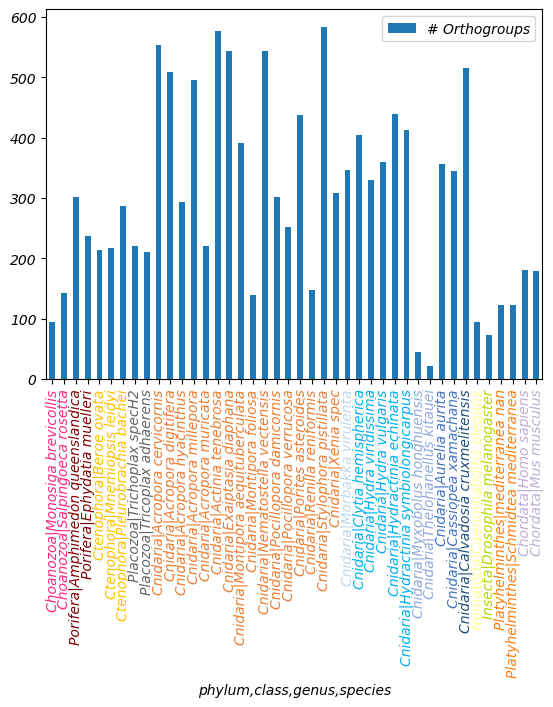

In [ ]:
HOG_count = HOG_count.loc[custom_order]

ax = HOG_count.plot(kind = "bar")

labels = [f"{i[0]}|{i[2]} {i[3]}" for i in HOG_count.index]

# Define a list to hold custom positions
positions = []

for idx, label in enumerate(HOG_count.index):
    first_level_value = label[0]
    if first_level_value == "Cnidaria":
        first_level_value = label[1]
    color = colors.get(first_level_value, 'black')  # Default to black if color is not found
    ax.get_xticklabels()[idx].set_color(color)
    position = idx * 1.5  # Adjust 1.5 as needed to control spacing
    positions.append(position)
ax.set_xticklabels(labels)

plt.title="Number of HOGs"
plt.savefig(graph_path / f"HOGs_per_species.svg")

In [ ]:
statistics= pd.read_csv(r"output\statistics.csv")
reduced = statistics["core_matrisome"]
reduced.index = statistics['taxonomic_id'].astype(str) + '_' + statistics['species_id'].astype(str)
reduced.index = pd.MultiIndex.from_tuples(reduced.index.str.split('_', expand=True),names = ["phylum","class","genus","species"])
size_OG = pd.concat([reduced,HOG_count],axis=1)
size_OG.columns = ["Core Matrisome size", "# Orthogroups"]
size_OG["Category"] = size_OG.index
size_OG["name"]= [str(name_list[2][0])+". "+ str(name_list[3]) for name_list in size_OG.Category]
size_OG['Color Category'] = size_OG.apply(lambda row: assign_color(row, col_name="Category"), axis=1)


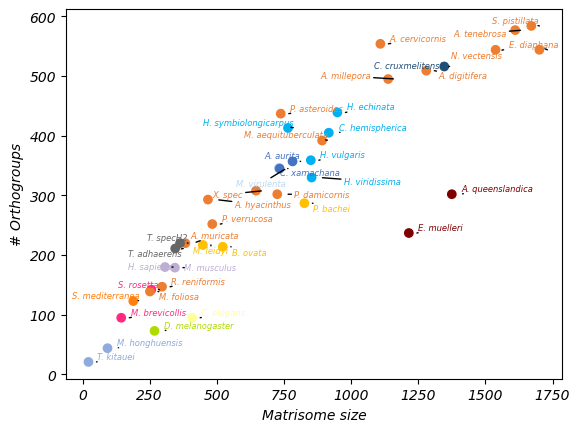

In [ ]:
label_names = ["A. queenslandica", "E. muelleri"]
scatter_plot_with_labels(size_OG,seq_row="Core Matrisome size",OG_row="# Orthogroups")
plt.savefig(output_path / "Orthogroup_Matrisome_size.svg")
plt.show()

We have to substaract the "other category so we only look at the core and ECm associated proteins.
We have this for Nematostella and for mouse and human

In [ ]:
#all orthogroups that have human or mouse sequneces are Core or mat associated
Hs_groups = set(HOGs.loc[~HOGs.Chordata_Vertebrata_Homo_sapiens.isna()].index)
Mm_groups = set(HOGs.loc[~HOGs.Chordata_Vertebrata_Mus_musculus.isna()].index)

# Nematostella orthogroups need to be identified
Nv_core_protein_ids = list(candidates.loc[candidates["Division manual"] != 'Other'].index)
#find all HOGs that include these ids
mask = HOGs["Cnidaria_Anthozoa_Nematostella_vectensis"].str.contains('|'.join(Nv_core_protein_ids))
Nv_groups = set(HOGs[mask.fillna(False)].index)
non_other_HOGs = Hs_groups | Mm_groups | Nv_groups

non_other_HOG_count = HOGs.loc[list(non_other_HOGs)]
nOHOGs=non_other_HOG_count.drop(["Gene Tree Parent Clade","OG"],axis=1)

In [ ]:
# Define a custom function to count comma-separated elements
def count_comma_separated_elements(cell):
    if pd.notna(cell):
        return cell.count(',') + 1
    else:
        return 0
    
# Apply the function to each column
count_results = nOHOGs.apply(lambda col: pd.Series({
    'clean_orthogroups': col.count(),
    'clean_sequences': col.apply(count_comma_separated_elements).sum()
})).T

count_results.index = pd.MultiIndex.from_tuples(count_results.index.str.split('_', expand=True),names = ["phylum","class","genus","species"])
size_OG =pd.concat([size_OG,count_results],axis=1)

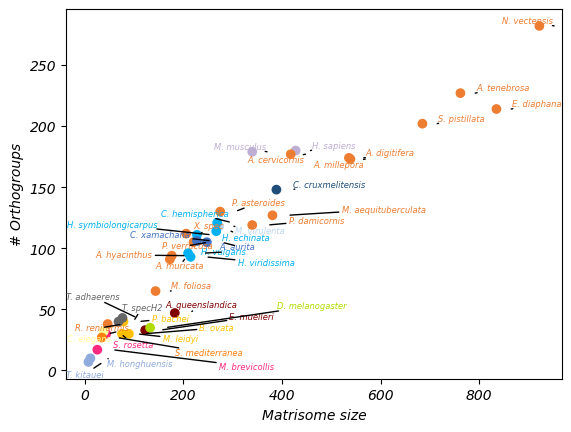

In [ ]:
scatter_plot_with_labels(size_OG,seq_row="clean_sequences",OG_row="clean_orthogroups")
plt.savefig(output_path / "no_other_Orthogroup_Matrisome_size.svg")
plt.show()

An interesting question to ask is how many proteins are in the differnten orthogroups for each species.

C:\Users\gideon.b\AppData\Local\Temp\ipykernel_15908\2594910142.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  HOG_count = HOGs.iloc[:, 2:].applymap(lambda x: [] if pd.isna(x) else x.split(",")).applymap(len)
100%|██████████| 45/45 [00:23<00:00,  1.89it/s]


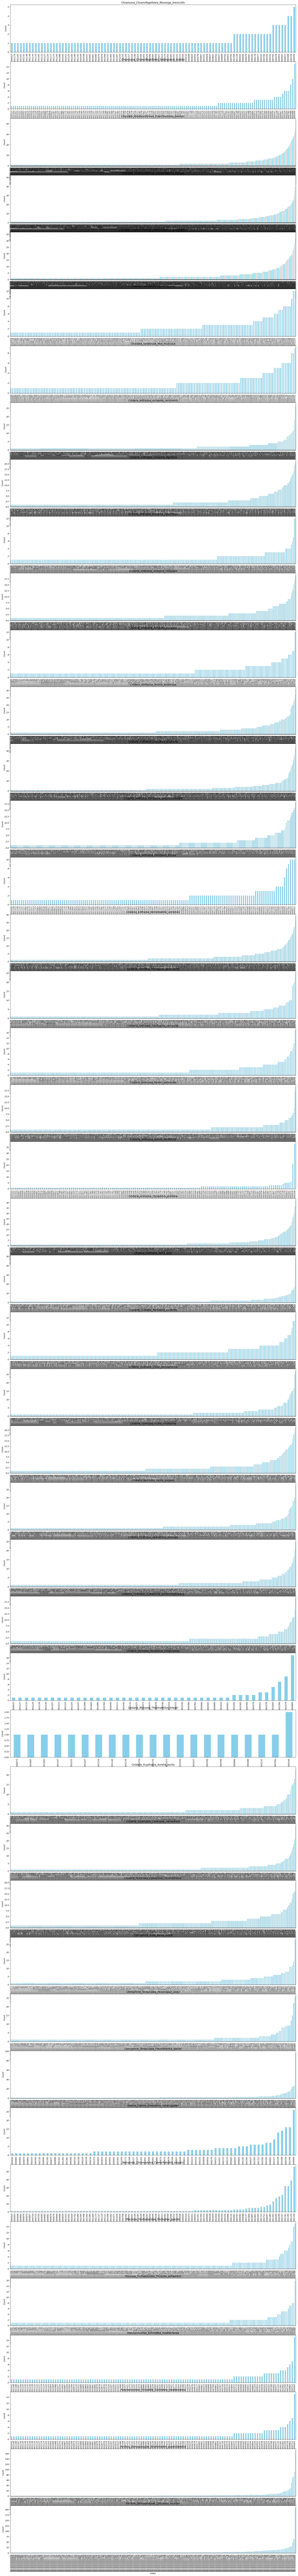

In [ ]:
#create a table that contains the number of proteins per HOG
HOG_count = HOGs.iloc[:, 2:].applymap(lambda x: [] if pd.isna(x) else x.split(",")).applymap(len)
HOG_count.to_csv(output_path / "HOG_count.csv")

# Create the figure and subplots
num_species = len(HOG_count.columns)
fig, axs = plt.subplots(nrows=num_species, ncols=1, figsize=(25, num_species*5))

# Plot each column's bar chart
for i, col in tqdm(enumerate(HOG_count.columns),total=len(HOG_count.columns)):
    
    # Filter out rows that are not 0
    col_values = HOG_count[col][HOG_count[col] != 0]
    col_values = col_values.sort_values()
    col_values.plot(kind='bar', ax=axs[i], color='skyblue')
    

    # Set subplot title and axis labels
    axs[i].set_title(col)
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Count')

# Adjust layout and spacing
#plt.tight_layout()
plt.savefig(graph_path / "Proteins_per_HOG.pdf")
plt.show()

## Export the orthogroups of specific species
first just the table

In [ ]:
species_of_interest = ['Chordata_Amphioxiformes_Branchiostoma_lanceolatum',
       'Chordata_Amphioxiformes_Branchiostoma_floridae']
#save the table
#HOGs[species_of_interest].dropna().to_csv(r"C:\Users\gideon.b\Desktop\Noriko\sponge_orthogroups.csv")

then also the sequences

In [ ]:
species_of_interest_list = ["_".join([ts_id.split("_")[-2],ts_id.split("_")[-1]]) for ts_id in species_of_interest]
sequence_folder = Path(r"output\Sequences")
reduced_HOGs = HOGs[species_of_interest].dropna()
reduced_HOGs.columns = species_of_interest_list

In [ ]:
def export_sequences(reduced_HOGs, sequence_folder, output_folder,output_formats=[("gb","genebank")]):
    """
    Process sequences from a pandas DataFrame of reduced HOGs and save them in the specified output folder.

    Args:
        reduced_HOGs (pandas.DataFrame): A DataFrame containing information about orthogroups and sequences.
            Index should be species names, and columns should be orthogroup names.
            Values should be comma-separated strings of sequence IDs.
        sequence_folder (str or Path): The path to the folder containing sequence files for each species.
        output_folder (str or Path): The path to the folder where the processed sequences will be saved.

    Returns:
        None
    """
    # Suppress BiopythonParserWarning
    warnings.filterwarnings("ignore", category=BiopythonParserWarning)

    # Create the destination folder (if it doesn't exist)
    destination_folder = Path(output_folder)
    destination_folder.mkdir(parents=True, exist_ok=True)

    # Iterate over each column (species) in the dataframe
    for species, orthogroups in reduced_HOGs.items():
        species = "_".join(species.rsplit('_', 2)[-2:])
        # Open the .gb source file
        source_path = sequence_folder / species / f"{species}_matrisome.gb"
        print(f"Read sequences for {source_path}")
        if source_path.exists():
            with open(source_path, "r") as source_file:
                source_records = SeqIO.to_dict(SeqIO.parse(source_file, "genbank"))

                # Iterate over each orthogroup in the column
                for orthogroup, value in orthogroups.items():
                    if value is not None and type(value) is not float:
                        seq_ids = value.split(',')
                        num_seqs= len(seq_ids)
                        seq_records = []
                        # Find sequences in the source file
                        for seq_id in seq_ids:
                            seq_id = seq_id.strip()
                            seq_id = seq_id.split(" ")[0]
                            if seq_id:
                                seq_records.append(source_records[seq_id])

                        if seq_records:
                            for record in seq_records:
                                record.annotations["molecule_type"] = "protein"
                           

                            # Write the sequences to the destination files
                            for format in output_formats:
                                # Create the destination file paths
                                destination_path = destination_folder / f"{species}_{orthogroup}.{format[0]}"
                            
                                gbs = SeqIO.write(seq_records, destination_path, format[1])



    warnings.resetwarnings()


In [ ]:
#export_sequences(reduced_HOGs, sequence_folder, output_folder)

## Export only the orthogroups that are specific for a species/taxon

In [ ]:
# optionally select new species or taxa
species_of_interest = species_of_interest
excluded_columns = ['OG', 'Gene Tree Parent Clade']

# Create a boolean mask for rows with at least one non-NaN value in the columns of interest
species_of_interest_mask = HOGs[species_of_interest].notna().any(axis=1)

# Create a DataFrame containing only the columns outside of the specified subset and excluded columns
other_columns_df = HOGs.drop(species_of_interest + excluded_columns, axis=1)

# Create a boolean mask for rows where all columns outside the subset and excluded columns are NaN
other_columns_mask = other_columns_df.isna().all(axis=1)

# Combine the two masks to get the final result
result = HOGs[species_of_interest_mask & other_columns_mask]

# Print the resulting DataFrame
exclusive_HOGs = result[species_of_interest]

In [ ]:
#export_sequences(exclusive_HOGs, sequence_folder, r"output\Sequences\_orthogroup_sequences")

So lets take a look at the phylogenetical distribution of the different orthogroups.

z:\Gideon\Labwork\2020\Proteome\mesoglea_protein_pipeline\.venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


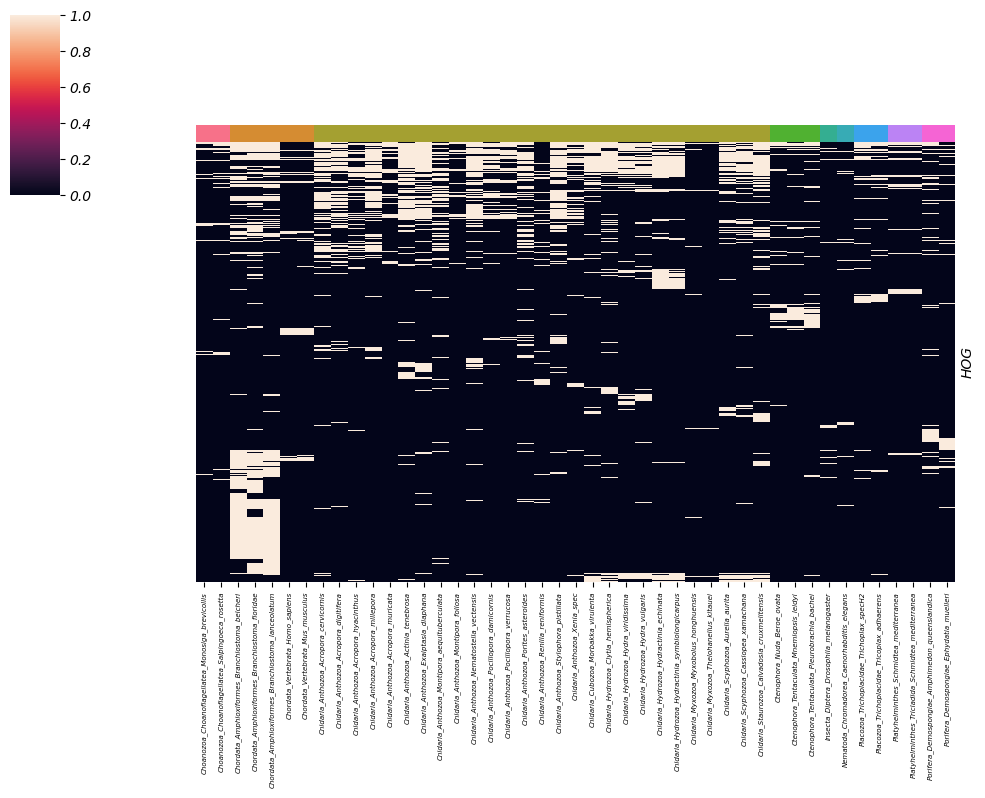

In [ ]:
bool_HOGs =  HOGs.iloc[:,2:].notna()
bool_HOGs = bool_HOGs.reindex(sorted(bool_HOGs.columns), axis=1)
# Extract the first element from each column name using split("_")
first_elements = [col.split("_")[0] for col in bool_HOGs.columns]

# Get unique first elements and assign colors to them
unique_elements = sorted(set(first_elements))
n_elements = len(unique_elements)
color_palette = sns.color_palette("husl", n_elements)

# Create a color map to map first elements to colors
element_to_color = {element: color for element, color in zip(unique_elements, color_palette)}

# Convert first elements to colors for each column
column_colors = [element_to_color[element] for element in first_elements]

cluster_map = sns.clustermap(bool_HOGs,xticklabels=True,yticklabels=False,col_colors=column_colors,col_cluster=False)
cluster_map.ax_row_dendrogram.set_visible(False)
cluster_map.ax_heatmap.set_xticklabels(cluster_map.ax_heatmap.get_xmajorticklabels(), fontsize = 5)
#cluster_map.ax_heatmap.set_yticklabels(cluster_map.ax_heatmap.get_ymajorticklabels(), fontsize = 2)
plt.savefig("output/graphs/HOGs_bool.svg")

In [ ]:
# Split column names and create multi-level index
columns = bool_HOGs.columns.str.split("_", expand=True)
multi_index = pd.MultiIndex.from_tuples(columns)

# Assign the multi-level index to the DataFrame
bool_HOGs.columns = multi_index

In [ ]:
def get_taxon_sub_HOGS(taxon_names, df=bool_HOGs):
    search_levels = {column_name: False for column_name in taxon_names}
    for level, level_categories in enumerate(df.columns.levels):
        for column_name in taxon_names:
            if column_name in level_categories:
                search_levels[column_name] = level
            if all(search_levels.values()):
                break
    return search_levels

def get_taxon_HOG_sets(taxon_names, df=bool_HOGs):
    search_levels = get_taxon_sub_HOGS(taxon_names=taxon_names, df=df)
    df_subsets = {}
    for column_name in taxon_names:
        sel_columns = df.xs(column_name, axis=1, level=search_levels[column_name], drop_level=False)
        df_subsets[column_name] = set(sel_columns[sel_columns.any(axis=1)].index)
    return df_subsets

def create_taxon_venn(taxon_names, df=bool_HOGs, true_venn = False):
    df_subsets = get_taxon_HOG_sets(taxon_names, df=bool_HOGs)
    num_sets = len(taxon_names)
    if true_venn:
        if num_sets == 2:
            venn_graph = venn2([df_subsets[taxon_names[0]], df_subsets[taxon_names[1]]], set_labels=taxon_names,set_colors = color_map)
        elif num_sets == 3:
            venn_graph = venn3([df_subsets[taxon_names[0]], df_subsets[taxon_names[1]], df_subsets[taxon_names[2]]], set_labels=taxon_names,set_colors = color_map)
        else:
            raise ValueError("Only 2 or 3 sets are supported for Venn diagrams.")
    else:
        venn_graph = venn(df_subsets,cmap = color_map)

    plt.show()


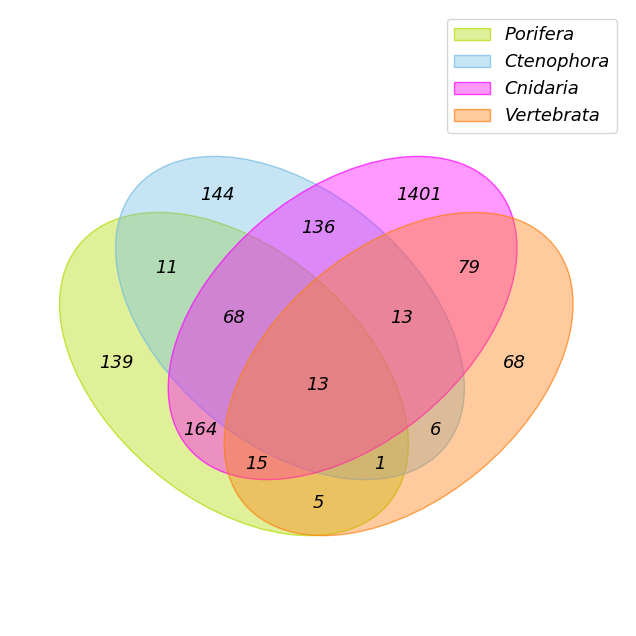

In [ ]:
taxon_names = ["Porifera","Ctenophora",'Cnidaria', 'Vertebrata']
create_taxon_venn(taxon_names)

What does this look like we we look at the actual numbe rof proteins in every HOG?

C:\Users\gideon.b\AppData\Local\Temp\ipykernel_15908\3758113278.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  HOGs_per_spec_count =  HOGs.iloc[:,2:].applymap(lambda x:calculate_list_length(x) if isinstance(x, str) else 0)
z:\Gideon\Labwork\2020\Proteome\mesoglea_protein_pipeline\.venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


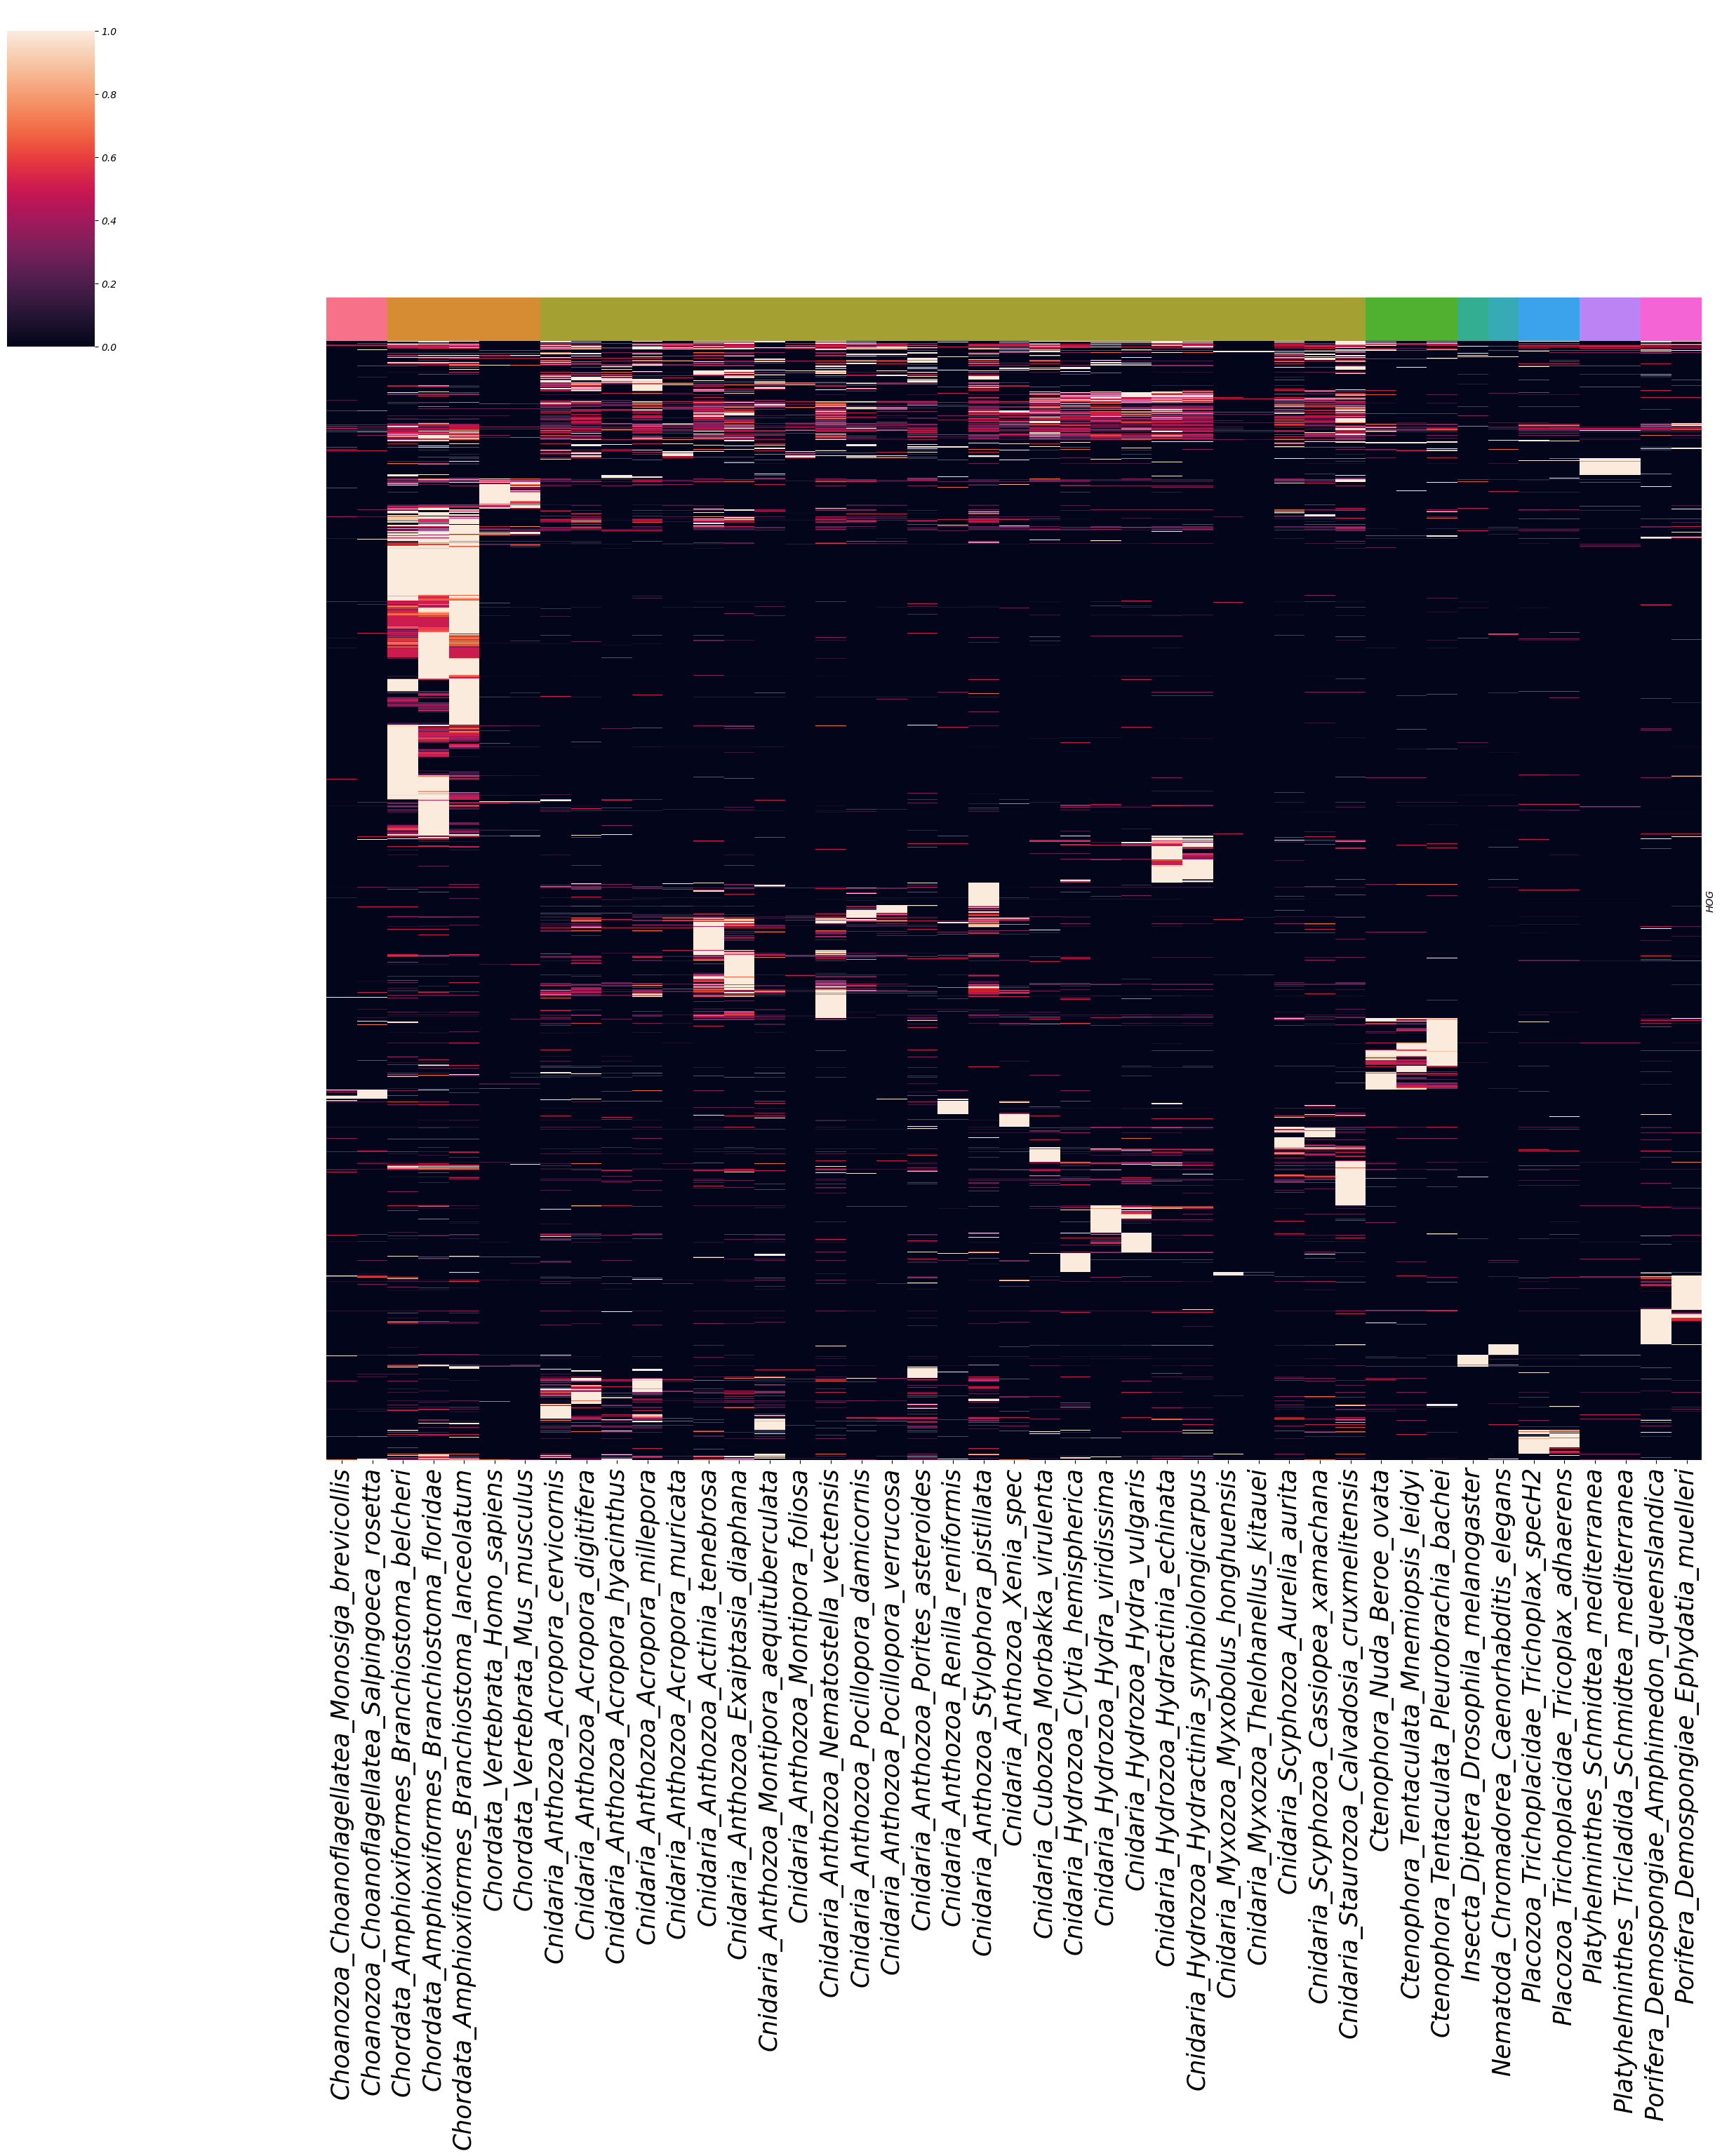

In [ ]:
def calculate_list_length(string_list):
    return len(string_list.split(', '))

HOGs_per_spec_count =  HOGs.iloc[:,2:].applymap(lambda x:calculate_list_length(x) if isinstance(x, str) else 0)
HOGs_per_spec_count = HOGs_per_spec_count.reindex(sorted(HOGs_per_spec_count.columns),axis=1)
# Get unique first elements and assign colors to them
unique_elements = sorted(set(first_elements))
n_elements = len(unique_elements)
color_palette = sns.color_palette("husl", n_elements)

# Create a color map to map first elements to colors
element_to_color = {element: color for element, color in zip(unique_elements, color_palette)}

# Convert first elements to colors for each column
column_colors = [element_to_color[element] for element in first_elements]

cluster_map = sns.clustermap(HOGs_per_spec_count,
        xticklabels=True,
        yticklabels=False,
        col_colors=column_colors,
        standard_scale=0,
        col_cluster=False,
        figsize=(25,25))
cluster_map.ax_row_dendrogram.set_visible(False)
cluster_map.ax_heatmap.set_xticklabels(cluster_map.ax_heatmap.get_xmajorticklabels(), fontsize = 25,)
plt.savefig("output/graphs/HOGs_count.svg")

What orthogroups are exclusive for the different taxa? We need ot create some function to analyse this

In [ ]:
def exclusivity_check(term,df = bool_HOGs):
  # find the columns that contain the string 'specific'
  cols_to_check = [col for col in df.columns if term in col]

  # create a boolean mask that checks if any of the values in the columns containing the specified string are True
  mask = df[cols_to_check].any(axis=1)

  # exclude any rows that have True values in columns not specified for checking
  mask &= ~df.loc[:, df.columns.difference(cols_to_check)].any(axis=1)

  # select the rows that match the mask
  result = df.loc[mask]

  # print the resulting dataframe
  return result

# we need to split the names into pairs of taxon and subtaxon 
def get_existing_pairs(cols):
    existing_pairs = set()
    for col in cols:
        levels = col
        for i in range(len(levels)-1):
            if levels[i+1] != "teleta":
                existing_pairs.add((levels[i], levels[i+1]))
    return existing_pairs

In [ ]:
#find the exclusive HOGs for each Taxon
sankey_list = list()
for pair1,pair2 in tax_pairs:
    res = exclusivity_check("{}".format(pair2)).shape[0]
    if res > 0 :
        sankey_list.append([pair1,pair2,res])
print(sankey_list)

NameError: name 'tax_pairs' is not defined

In [ ]:
exclusivity_check("Porifera",df = bool_HOGs).shape[0]

131

In [ ]:
HOG_size =  bool_HOGs.shape[0]
tax_pairs = get_existing_pairs(bool_HOGs.columns)
# the phyla need to be paired with the overall matrisome
phyla = set(first_elements)

#find the exclusive HOGs for each Taxon
sankey_list = list()
for pair1,pair2 in tax_pairs:
    res = exclusivity_check("{}".format(pair2)).shape[0]
    if res > 0 :
        sankey_list.append([pair1,pair2,res])
top_level_size = 0
for phylum in phyla:
    res = exclusivity_check(phylum).shape[0]
    if res > 0 :
        top_level_size += res
        sankey_list.append(["All in silico matrisome HOGs",phylum,res])
print(top_level_size)
#sankey_list.append(["All in silico matrisome HOGs","shared",HOG_size - top_level_size])    

#create a pandas df
sankey_df = pd.DataFrame(sankey_list)
sankey_df.columns = ["source","target","value"]

hv.extension('bokeh')

sankey = hv.Sankey(sankey_df, label='Exlusive hirarchical orthogroups')
sankey.output_backend = "svg"
sankey.opts(label_position='outer', edge_color='target', node_color='index', cmap='tab20',node_padding=9,node_sort = True)

NameError: name 'bool_HOGs' is not defined

In [ ]:
def export_svg(obj, filename):
    plot_state = hv.renderer('bokeh').get_plot(obj).state
    plot_state.output_backend = 'svg'
    export_svgs(plot_state, filename=filename)

export_svg(sankey, graph_path / 'exclusive_HOGs_sankey.svg')

NameError: name 'sankey' is not defined

What HOGs are exclusive to Cnidarians?

In [ ]:
cnidaria_columns = [col for col in bool_HOGs.columns if 'Cnidaria' in col]
condition = (bool_HOGs[cnidaria_columns].any(axis=1)) & (~bool_HOGs.drop(cnidaria_columns, axis=1).any(axis=1))
result = bool_HOGs[condition]
result

Annelida         Choanozoa                   Chordata  \
              Pleistoannelida Choanoflagellatea             Amphioxiformes   
                    Capitella          Monosiga Salpingoeca  Branchiostoma   
                       teleta       brevicollis     rosetta       belcheri   
HOG                                                                          
N0.HOG0000004           False             False       False          False   
N0.HOG0000006           False             False       False          False   
N0.HOG0000007           False             False       False          False   
N0.HOG0000016           False             False       False          False   
N0.HOG0000019           False             False       False          False   
...                       ...               ...         ...            ...   
N0.HOG0003486           False             False       False          False   
N0.HOG0003487           False             False       False          False   
N0.HOG0003488           False             False       False          False   
N0.HOG0003489           False             False       False          False   
N0.HOG0003490           False             False       False          False   

                                                          Cnidaria             \
                                   Vertebrata             Anthozoa              
                                         Homo      Mus    Acropora              
              floridae lanceolatum    sapiens musculus cervicornis digitifera   
HOG                                                                             
N0.HOG0000004    False       False      False    False       False      False   
N0.HOG0000006    False       False      False    False       False       True   
N0.HOG0000007    False       False      False    False       False       True   
N0.HOG0000016    False       False      False    False        True       True   
N0.HOG0000019    False       False      False    False       False      False   
...                ...         ...        ...      ...         ...        ...   
N0.HOG0003486    False       False      False    False       False      False   
N0.HOG0003487    False       False      False    False       False      False   
N0.HOG0003488    False       False      False    False       False      False   
N0.HOG0003489    False       False      False    False       False      False   
N0.HOG0003490    False       False      False    False       False      False   

               ...  Ctenophora                    Insecta       Nematoda  \
               ... Tentaculata                    Diptera    Chromadorea   
               ...  Mnemiopsis Pleurobrachia   Drosophila Caenorhabditis   
               ...      leidyi        bachei melanogaster        elegans   
HOG            ...                                                         
N0.HOG0000004  ...       False         False        False          False   
N0.HOG0000006  ...       False         False        False          False   
N0.HOG0000007  ...       False         False        False          False   
N0.HOG0000016  ...       False         False        False          False   
N0.HOG0000019  ...       False         False        False          False   
...            ...         ...           ...          ...            ...   
N0.HOG0003486  ...       False         False        False          False   
N0.HOG0003487  ...       False         False        False          False   
N0.HOG0003488  ...       False         False        False          False   
N0.HOG0003489  ...       False         False        False          False   
N0.HOG0003490  ...       False         False        False          False   

                    Placozoa                  Platyhelminthes      Porifera  \
              Trichoplacidae                       Tricladida  Demospongiae   
                  Trichoplax        Tricoplax       Schmidtea    Amphimedon   
                     